## MNIST Classification problem 
### HODA AKL
HW 4 - EEL6814. <br>
Data: <br>
    1. ✅ Load the data. <br> 
    2. ✅make sure it is balanced<br> 
    3. ✅scale <br>
    4. ✅Split train to train and validation. <br>
    5. ✅shuffle<br>
___________________________
network: <br>
    1. ✅Create <br>
    2. ✅Test <br>
    3. ✅run - <br>
    * ✅ batches <br>
    * ✅ run on validation set <br>
    * ✅early stopping 
    4. ✅extract plots. <br>
    5. ✅Confusion matrix and test accuracy<br>


In [1]:
import gzip
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
##################
import torch
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F  # All functions that don't have any parameters
from torch.utils.data import (
    DataLoader,
)  # Gives easier dataset managment and creates mini batches
import torchvision.datasets as datasets  # Has standard datasets we can import in a nice way
import torchvision.transforms as transforms  # Transformations we can perform on our dataset
##########################
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
# Simple CNN

# Loading The data

In [2]:
# This is the notebook where I load the data 
f_train_im = gzip.open('train-images-idx3-ubyte.gz','r')
f_train_lab = gzip.open('train-labels-idx1-ubyte.gz','r')
f_test_im = gzip.open('t10k-images-idx3-ubyte.gz','r')
f_test_lab = gzip.open('t10k-labels-idx1-ubyte.gz','r')
image_size = 28
lab_size = 1
n_train = 60000
n_test = 10000
f_train_im.read(16)
f_train_lab.read(8)
f_test_im.read(16)
f_test_lab.read(8)
buf_tr_im = f_train_im.read(image_size * image_size * n_train)
buf_tr_lab = f_train_lab.read(lab_size * n_train)
buf_test_im = f_test_im.read(image_size * image_size * n_test)
buf_test_lab = f_test_lab.read(lab_size * n_train)
train_im = np.frombuffer(buf_tr_im, dtype=np.uint8).astype(np.float32)
train_im = train_im.reshape(n_train, image_size, image_size, 1)
test_im = np.frombuffer(buf_test_im, dtype=np.uint8).astype(np.float32)
test_im = test_im.reshape(n_test, image_size, image_size, 1)
train_labels = np.frombuffer(buf_tr_lab, dtype=np.uint8).astype(np.int64)
train_labels = train_labels.reshape(n_train,1)
test_labels = np.frombuffer(buf_test_lab, dtype=np.uint8).astype(np.int64)
test_labels = test_labels.reshape(n_test,1)

In [3]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [4]:
#make sure data is balanced 
Dictionary_counts = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}
total = 0
for i in train_labels:
    digit = i[0]
    Dictionary_counts[digit] +=1
    total +=1
for key in range(10):
    Dictionary_counts[key] = Dictionary_counts[key]/total
print(Dictionary_counts)

{0: 0.09871666666666666, 1: 0.11236666666666667, 2: 0.0993, 3: 0.10218333333333333, 4: 0.09736666666666667, 5: 0.09035, 6: 0.09863333333333334, 7: 0.10441666666666667, 8: 0.09751666666666667, 9: 0.09915}


In [5]:
print(train_im.shape)
print(test_im.shape)
print(train_labels.shape)
print(test_labels.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)
(60000, 1)
(10000, 1)


In [6]:
# Data Processing
#scaling 
# reshape the data to be able to be scaled 
Train_Im_Reshaped = train_im.reshape(train_im.shape[0],28*28)
Test_Im_Reshaped = test_im.reshape(test_im.shape[0],28*28)
from sklearn.preprocessing import MinMaxScaler
scl = MinMaxScaler()
scl.fit(Train_Im_Reshaped)
Train_Im_Scaled = scl.transform(Train_Im_Reshaped)
Test_Im_Scaled = scl.transform(Test_Im_Reshaped)
#reshape data back to images 
Train_Im_2d_np = Train_Im_Scaled.reshape(Train_Im_Scaled.shape[0], 28,28,1)
Test_Im_2d_np  = Test_Im_Scaled.reshape(Test_Im_Scaled.shape[0],28,28,1)
#change all to tensors 
X_train_all = torch.from_numpy(Train_Im_2d_np)
X_test = torch.from_numpy(Test_Im_2d_np)
y_Train_all = torch.from_numpy(train_labels)
y_test = torch.from_numpy(test_labels)
#one hot encoding the test labels labels 
y_test_one_hot = F.one_hot(y_test)
y_train_all_one_hot = F.one_hot(y_Train_all)
# Train validation split 
X_Train,X_Val,Y_Train_oneHot,Y_Val_oneHot = train_test_split(X_train_all,y_train_all_one_hot, test_size=0.1, random_state=42, shuffle = True)
#Changing shape again to feed into the network 
X_Train=X_Train.view([X_Train.shape[0],1,28,28])
X_Val=X_Val.view([X_Val.shape[0],1,28,28])

In [7]:
# What we have is X_Train, X_Val, T_Train_oneHo, Y_Val_oneHot
# X_test, y_test_one_Hot

# Creating the network 

In [8]:
class CNN(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=8,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv2 = nn.Conv2d(
            in_channels=8,
            out_channels=16,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.fc1 = nn.Linear(16 * 7 * 7, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)

        return F.softmax(x, dim =1)


In [9]:
model = CNN()
print(model)
x = torch.randn(1,1,28,28)
print(x.shape)
print(model(x).shape)

CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=784, out_features=10, bias=True)
)
torch.Size([1, 1, 28, 28])
torch.Size([1, 10])


In [10]:
Model_3 = CNN()

In [11]:
# Hyperparameters
in_channel = 1
num_classes = 10
learning_rate = 0.001
batch_size = 128
num_epochs = 100
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(Model_3.parameters(), lr = 0.001)

In [12]:
# initialize the loss and accuracy arrays 
Loss_Arr_Train =  -1*torch.ones(num_epochs)
Loss_Arr_Val  =-1* torch.ones(num_epochs)
Acc_Arr_Train = -1*torch.ones(num_epochs)
Acc_Arr_Val = -1*torch.ones(num_epochs)    
Val_n = Y_Val_oneHot.shape[0] #number of validation points 
Train_n = Y_Train_oneHot.shape[0] 
y_val_resh = Y_Val_oneHot.view([Val_n,num_classes])
y_train_resh = Y_Train_oneHot.view([Train_n, num_classes])
real_classes_val = torch.argmax(y_val_resh, dim = 1)
real_classes_train = torch.argmax(y_train_resh, dim=1)

In [13]:
# training th emodel for 100 epochs

In [14]:
from pytorchtools import EarlyStopping

In [15]:
# 
early_stopping = EarlyStopping(patience=20, verbose=True)
for epoch in range(num_epochs):
#     epoch_loss = 0
    compiled_loss = 0
    # get the batch in X and Y 
    s = 0 
    for i in tqdm(range(0, len(X_Train), batch_size)):
        s = s+1 
        batch_X = X_Train[i:i+batch_size,:,:,:]
#         print('length of batch x = ', len(batch_X))
        batch_Y = Y_Train_oneHot[i:i+batch_size]
        batch_Y = batch_Y.view(batch_Y.shape[0],num_classes)
        train_target = torch.argmax(batch_Y, dim =1)
        #zero the grad
        Model_3.zero_grad()
        outputs = Model_3(batch_X) 
#         outputs = 
        loss_train = loss_function(outputs, train_target)
        compiled_loss += loss_train
        #backward propagation
        loss_train.backward()
        # update weights 
        optimizer.step()
        # record the loss 
#         train_losses.append(loss.item())
#     print(f"Epoch: {epoch}. Loss:{loss}")
#     Model_3.eval()
    outputs_onehot_val = Model_3(X_Val)
    outputs_onehot_train = Model_3(X_Train)
    predicted_classes_val = torch.argmax(outputs_onehot_val, dim = 1)
    predicted_classes_train = torch.argmax(outputs_onehot_train, dim = 1)
    accurate_num_val = len(torch.where(real_classes_val == predicted_classes_val)[0])
    accurate_num_train = len(torch.where(real_classes_train == predicted_classes_train)[0])
    Acc_Arr_Val[epoch] = accurate_num_val/Val_n
    Acc_Arr_Train[epoch] = accurate_num_train/Train_n
    with torch.no_grad():
        Loss_Arr_Val[epoch] =loss_function(outputs_onehot_val, real_classes_val)
        Loss_Arr_Train[epoch] = compiled_loss/s
    
    print('Epoch ', epoch, 'finished training')
    print('Train loss = ' ,Loss_Arr_Train[epoch], ' , Train Accuracy = ',   Acc_Arr_Train[epoch])
    print('Val loss = ' ,Loss_Arr_Val[epoch], ' , Val Accuracy = ',   Acc_Arr_Val[epoch])
    print()
#             early_stopping needs the validation loss to check if it has decresed, 
#         and if it has, it will make a checkpoint of the current model
    early_stopping(Loss_Arr_Val[epoch], Model_3)

    if early_stopping.early_stop:
        print("Early stopping")
        break

# load the last checkpoint with the best model
Model_3.load_state_dict(torch.load('checkpoint.pt'))

  0%|▍                                                                                 | 2/422 [00:00<00:21, 19.99it/s]

Epoch  0 finished training
Train loss =  tensor(1.7125)  , Train Accuracy =  tensor(0.8524)
Val loss =  tensor(1.6112)  , Val Accuracy =  tensor(0.8562)

Validation loss decreased (inf --> 1.611212).  Saving model ...


  0%|                                                                                          | 0/422 [00:00<?, ?it/s]

Epoch  1 finished training
Train loss =  tensor(1.6012)  , Train Accuracy =  tensor(0.8733)
Val loss =  tensor(1.5889)  , Val Accuracy =  tensor(0.8753)

Validation loss decreased (1.611212 --> 1.588918).  Saving model ...


 25%|████████████████████▎                                                           | 107/422 [00:05<00:15, 19.96it/s]


KeyboardInterrupt: 

In [ ]:
# Now choose the arrays that are posibitive
# Loss_Arr_Train =  -1*torch.ones(num_epochs)
# Loss_Arr_Val  =-1* torch.ones(num_epochs)
# Acc_Arr_Train = -1*torch.ones(num_epochs)
# Acc_Arr_Val = -1*torch.ones(num_epochs)    
Loss_Arr_Train_idx = torch.where(Loss_Arr_Train>0)
LossArrTrain = Loss_Arr_Train[Loss_Arr_Train_idx[0]]
#
Loss_Arr_Val_idx = torch.where(Loss_Arr_Val>0)
LossArrVal = Loss_Arr_Val[Loss_Arr_Val_idx[0]]
#
Acc_Arr_Train_idx = torch.where(Acc_Arr_Train>0)
AccArrTrain = Acc_Arr_Train[Acc_Arr_Train_idx[0]]
#
Acc_Arr_Val_idx = torch.where(Acc_Arr_Val>0)
AccArrVal = Acc_Arr_Val[Acc_Arr_Val_idx[0]]

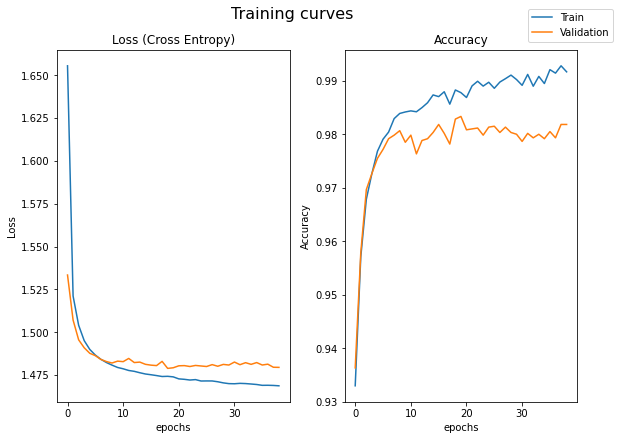

In [80]:
fig, axs = plt.subplots(1, 2,figsize=(8,6), constrained_layout = True)
# fig.tight_layout()
# axs[0, 0].plot(x, y)
axs[0].set_title('Loss (Cross Entropy)')
axs[1].set_title('Accuracy')
# axs[0, 2].set_title('Confusion Matrix')
a1 = axs[0].plot(LossArrTrain)
a2 = axs[0].plot(LossArrVal)
b1 = axs[1].plot(AccArrTrain, label ='Train')
b2 = axs[1].plot(AccArrVal, label ='Validation')
axs[0].set(xlabel='epochs', ylabel = 'Loss')
axs[1].set(xlabel='epochs', ylabel = 'Accuracy')
# axs[0].legend((a1, a2), ('oscillatory', 'damped'), loc='upper right', shadow=True)
fig.suptitle('Training curves', fontsize=16)
fig.legend(bbox_to_anchor=(.9, 1), loc='upper left')
plt.show()
# axs[-1, -1].axis('off')


In [99]:
# testing 
X_test = X_test.view(X_test.shape[0],1,28,28)
y_test = torch.flatten(y_test)
Y_predictions = Model_3(X_test)
labels_pred = torch.argmax(Y_predictions, dim = 1)
labels_pred = torch.flatten(labels_pred)
acc = len(torch.where(y_test == labels_pred)[0])
acc_perc = acc/ len(y_test)

In [101]:
acc_perc

0.9856

In [ ]:
# get the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, labels_pred)

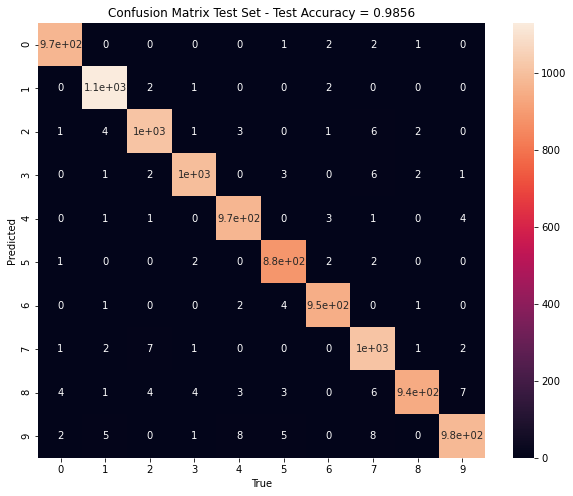

In [112]:
import pandas as pd
from sklearn.metrics import confusion_matrix
ConfMat = confusion_matrix(y_test, labels_pred)
import seaborn as sns
confMat = np.transpose(ConfMat)
df_cm = pd.DataFrame(ConfMat)
plt.figure(figsize = (10,8))
# plt.imshow(ConfMat, cmap = 'hot')
plt.xlabel('Preidcted')
plt.ylabel('true')
ax = sns.heatmap(df_cm, annot=True)
ax.set(title = 'Confusion Matrix Test Set - Test Accuracy = ' + str(acc_perc), xlabel = 'True', ylabel = 'Predicted')
plt.show()